# Data Exploration

Script to do preliminary data analysis and generate distribution plots and Kaplan Meieir analysis

In [24]:
from importlib import reload
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm import tqdm

# Imports from my own code
from patient_data_split import pat_train_test_split

In [25]:
# Constants for development
FILESTOLOAD = 2888 # 2888 is all of them
imdim_from_preprocessing = 256 # must match opt.ImageSize in image preprocessing configuration files
train_valid_split = 0.8
random_seed = 16

In [26]:
# Path to CSVs that connect patient id to slices and rfs label
zero_info_path = "/Users/katyscott/Documents/ICC/Data/Labels/" + str(imdim_from_preprocessing) +"/RFS_all_tumors_zero.csv"

# Reading in info for zero background images
info = pd.read_csv(zero_info_path)
image_fnames = np.asarray(info.iloc[:, 0])
pat_num = np.asarray(info.iloc[:, 1])
slice_num = np.asarray(info.iloc[:, 2])
rfs_event = np.asarray(info.iloc[:, 3])
rfs_time = np.asarray(info.iloc[:, 4])

# Confirming loading in happened correctly
print("Total label count (should be 2888):", rfs_event.shape)
print("First RFS time label (should be 0.6):", rfs_time[0])

Total label count (should be 2888): (2888,)
First RFS time label (should be 0.6): 0.6


100%|██████████| 2888/2888 [24:43<00:00,  1.95it/s]


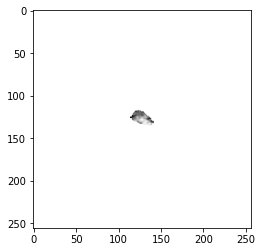

In [28]:
zero_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/Zero/'

images = np.empty((1,imdim_from_preprocessing,imdim_from_preprocessing))
file_count = 0
for image_file in tqdm(image_fnames):
    if file_count >= FILESTOLOAD:
        break
    else:
        file_count += 1
    #     print("Loading: ", image_file)
        # Load in file as an numpy array
        img = np.fromfile(zero_image_path + image_file)
        # Reshape image from 1D to 2D array
        img_2D = np.reshape(img, (imdim_from_preprocessing,imdim_from_preprocessing))
        # Add third dimension so image can be added to main images array
        img_final_3D = np.reshape(img_2D, (1,) + img_2D.shape)
        images = np.append(images, img_final_3D, axis=0)

images = np.delete(images, 0, axis=0)

# Confirming images loaded in properly
plt.imshow(images[0], cmap='Greys')

### Split data into training and validation sets:

In [30]:
# Splitting samples by patient and censoring code
train_slice_indices, val_slice_indices = pat_train_test_split(pat_num[:FILESTOLOAD], rfs_event[:FILESTOLOAD], train_valid_split, random_seed)

# Get training images
train_slices = images[train_slice_indices,:,:]#[:][:]
train_slices = train_slices.squeeze() # Remove first dim of size 1

# Get training labels
train_time = rfs_time[train_slice_indices]
train_event = rfs_event[train_slice_indices]
print("Training set: ", train_slices.shape)
print("Training time labels: ", train_time.shape)
print("Training event labels: ", train_event.shape)

# Get validation images
val_slices = images[val_slice_indices,:,:]
val_slices = val_slices.squeeze() # Remove first dim of size 1

# Get validation labels
val_time = rfs_time[val_slice_indices]
val_event = rfs_event[val_slice_indices]
print("Validation set: ", val_slices.shape)
print("Validation time labels: ", val_time.shape)
print("Validation event labels: ", val_event.shape)

Training set:  (2557, 256, 256)
Training time labels:  (2557,)
Training event labels:  (2557,)
Validation set:  (686, 256, 256)
Validation time labels:  (686,)
Validation event labels:  (686,)


In [9]:
info.rename(columns={"Pat ID": "Pat_ID", "Slice Num": "Slice_Num", "RFS Code": "RFS_Code", "RFS Time":"RFS_Time"}, inplace=True)

# Data distribution plots

Text(0.5, 1.0, 'Slice RFS Time')

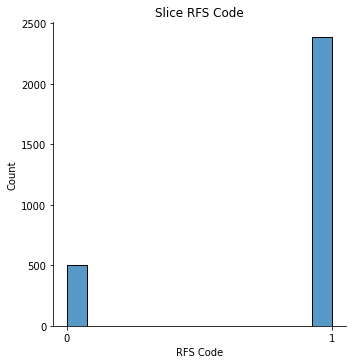

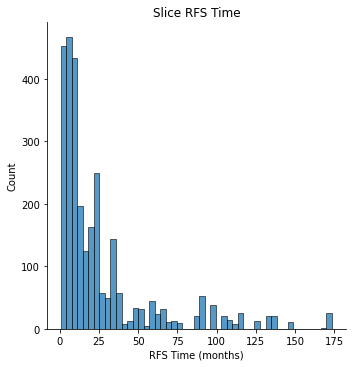

In [10]:
# Distribution plots for slice level labels, total dataset
slice_rfs_code_plt = sns.displot(info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Slice RFS Code")

slice_rfs_time_plt = sns.displot(info, x="RFS_Time")
plt.xlabel("RFS Time (months)")
plt.title("Slice RFS Time")

Text(0.5, 1.0, 'Patient RFS Time')

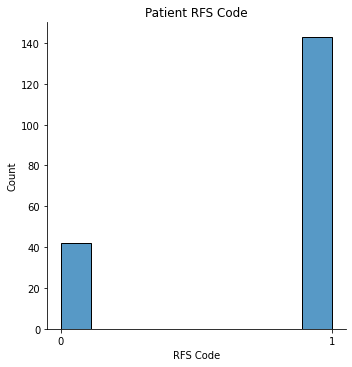

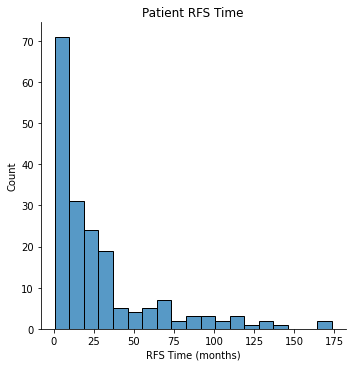

In [11]:
# Distribution plots for patient level labels, total dataset
pat_info = info.drop_duplicates("Pat_ID")
pat_rfs_code_plt = sns.displot(pat_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Patient RFS Code")

pat_rfs_time_plt = sns.displot(pat_info, x="RFS_Time", )
plt.xlabel("RFS Time (months)")
plt.title("Patient RFS Time")

In [15]:
# Getting label info for train and testing sets
training_info = info.iloc[train_slice_indices]
validation_info = info.iloc[val_slice_indices]

Text(0.5, 1.0, 'Training Set - Patient RFS Time')

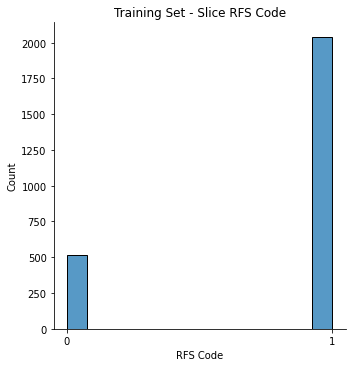

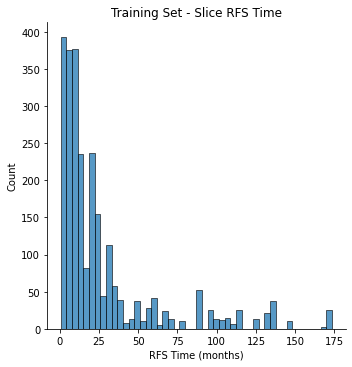

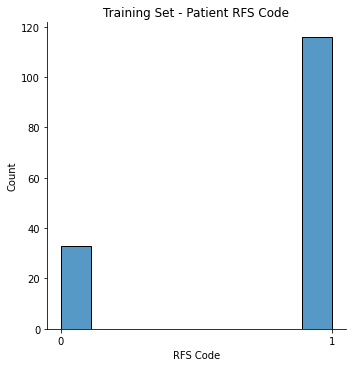

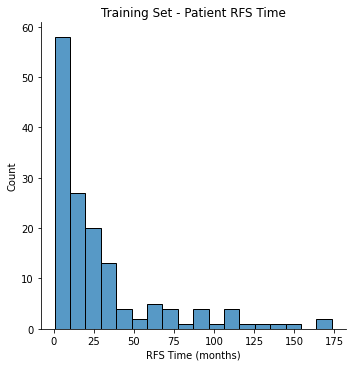

In [13]:
# Distribution plots for slice level labels, training set
trainslice_rfs_code_plt = sns.displot(training_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Training Set - Slice RFS Code")

trainslice_rfs_time_plt = sns.displot(training_info, x="RFS_Time")
plt.xlabel("RFS Time (months)")
plt.title("Training Set - Slice RFS Time")

# Distribution plots for patient level labels, training set
train_pat_info = training_info.drop_duplicates("Pat_ID")
trainpat_rfs_code_plt = sns.displot(train_pat_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Training Set - Patient RFS Code")

trainpat_rfs_time_plt = sns.displot(train_pat_info, x="RFS_Time", )
plt.xlabel("RFS Time (months)")
plt.title("Training Set - Patient RFS Time")

Text(0.5, 1.0, 'Validation Set - Patient RFS Time')

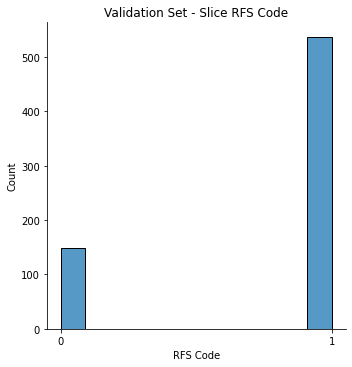

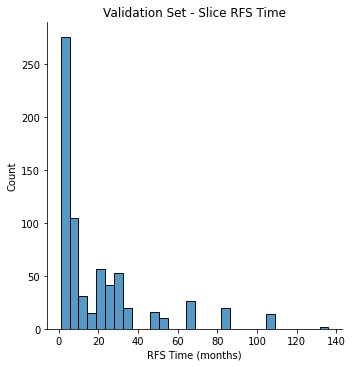

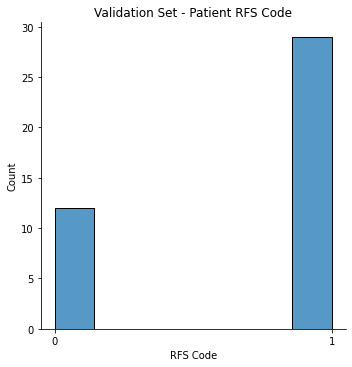

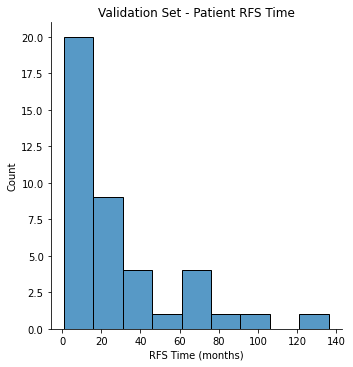

In [16]:
# Distribution plots for slice level labels, validation set
valslice_rfs_code_plt = sns.displot(validation_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Validation Set - Slice RFS Code")

testslice_rfs_time_plt = sns.displot(validation_info, x="RFS_Time")
plt.xlabel("RFS Time (months)")
plt.title("Validation Set - Slice RFS Time")

# Distribution plots for patient level labels, testing set
val_pat_info = validation_info.drop_duplicates("Pat_ID")
valpat_rfs_code_plt = sns.displot(val_pat_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Validation Set - Patient RFS Code")

valpat_rfs_time_plt = sns.displot(val_pat_info, x="RFS_Time", )
plt.xlabel("RFS Time (months)")
plt.title("Validation Set - Patient RFS Time")

# Kaplan Meier Survival Curve

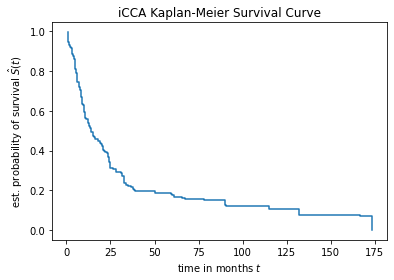

In [18]:
# Convert rfs_event from numeric to boolean for use in sksurv
b_rfs_event = np.array(rfs_event, dtype=bool)
# Creating structured array for kaplan_meier_estimator
rfs_type = np.dtype([('Status','bool'), ('Time', 'f')])
rfs = np.empty(len(rfs_event),dtype=rfs_type)
rfs['Status'] = b_rfs_event
rfs['Time'] = rfs_time

time, survival_prob = kaplan_meier_estimator(rfs['Status'], rfs['Time'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time in months $t$")
plt.title("iCCA Kaplan-Meier Survival Curve")

plt.show()

# Linear Regression

In [31]:
train_1D = np.reshape(train_slices, (train_slices.shape[0], train_slices.shape[1]*train_slices.shape[2]))
val_1D = np.reshape(val_slices, (val_slices.shape[0], val_slices.shape[1]*val_slices.shape[2]))
# train_1D = train_1D[0:100,:]
# linreg_labels = train_event[0:100]
print(train_1D.shape)
print(val_1D.shape)

(2557, 65536)
(686, 65536)


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regression_model = LinearRegression().fit(train_1D, train_event)
regression_model.score(val_1D, val_event)

-1.2546250184188916e+16

# Cox Proportional Hazards

Tried to get this to work, but need to perform feature selection first.

In [ ]:
# Convert rfs_event from numeric to boolean for use in sksurv
b_rfs_event = np.array(rfs_event, dtype=bool)
# Creating structured array for kaplan_meier_estimator
rfs_type = np.dtype([('Status','bool'), ('Time', 'f')])
rfs = np.empty(len(rfs_event),dtype=rfs_type)
rfs['Status'] = b_rfs_event
rfs['Time'] = rfs_time

rfs_train = rfs[train_slice_indices]
rfs_val = rfs[val_slice_indices]

train_1D = np.reshape(train_slices, (train_slices.shape[0], train_slices.shape[1]*train_slices.shape[2]))
val_1D = np.reshape(test_slices, (val_slices.shape[0], val_slices.shape[1]*val_slices.shape[2]))

print(train_1D.shape)
print(rfs_train.shape)
estimator = CoxPHSurvivalAnalysis().fit(train_1D, rfs_train)

risk_score = estimator.predict(train_1D)

# score = (train_1D, rfs_train)

# print(risk_score[1])